In [1]:
!pip install torchmetrics

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import time

# Load data files
cases_df = pd.read_csv('dataset/scin_cases.csv')
labels_df = pd.read_csv('dataset/scin_labels.csv')

# Merge data frames on case_id
merged_df = pd.merge(cases_df, labels_df, on='case_id')

In [3]:
merged_df.columns

Index(['case_id', 'source', 'release', 'year', 'age_group', 'sex_at_birth',
       'fitzpatrick_skin_type',
       'race_ethnicity_american_indian_or_alaska_native',
       'race_ethnicity_asian', 'race_ethnicity_black_or_african_american',
       'race_ethnicity_hispanic_latino_or_spanish_origin',
       'race_ethnicity_middle_eastern_or_north_african',
       'race_ethnicity_native_hawaiian_or_pacific_islander',
       'race_ethnicity_white', 'race_ethnicity_other_race',
       'race_ethnicity_prefer_not_to_answer', 'textures_raised_or_bumpy',
       'textures_flat', 'textures_rough_or_flaky', 'textures_fluid_filled',
       'body_parts_head_or_neck', 'body_parts_arm', 'body_parts_palm',
       'body_parts_back_of_hand', 'body_parts_torso_front',
       'body_parts_torso_back', 'body_parts_genitalia_or_groin',
       'body_parts_buttocks', 'body_parts_leg', 'body_parts_foot_top_or_side',
       'body_parts_foot_sole', 'body_parts_other',
       'condition_symptoms_bothersome_appearan

In [4]:
merged_df['dermatologist_gradable_for_skin_condition_1'].value_counts()

dermatologist_gradable_for_skin_condition_1
DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT                     3049
NO_IMAGE_QUALITY_INSUFFICIENT                            1925
YES_IMAGE_QUALITY_SUFFICIENT_NO_DISCERNIBLE_PATHOLOGY      59
Name: count, dtype: int64

In [5]:
merged_df['dermatologist_gradable_for_skin_condition_2'].value_counts()

dermatologist_gradable_for_skin_condition_2
DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT                     464
NO_IMAGE_QUALITY_INSUFFICIENT                            245
YES_IMAGE_QUALITY_SUFFICIENT_NO_DISCERNIBLE_PATHOLOGY      7
Name: count, dtype: int64

In [6]:
merged_df['dermatologist_gradable_for_skin_condition_3'].value_counts()

dermatologist_gradable_for_skin_condition_3
DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT                     461
NO_IMAGE_QUALITY_INSUFFICIENT                            243
YES_IMAGE_QUALITY_SUFFICIENT_NO_DISCERNIBLE_PATHOLOGY     12
Name: count, dtype: int64

In [7]:
merged_df['dermatologist_skin_condition_confidence'].value_counts()

dermatologist_skin_condition_confidence
[]                          1972
[5]                          312
[4]                          208
[2, 2, 2]                    178
[2, 2]                       176
                            ... 
[3, 3, 2, 4, 1, 1]             1
[1, 1, 2, 2, 5]                1
[1, 4, 1, 4, 2]                1
[4, 4, 3, 1, 1]                1
[4, 1, 1, 1, 1, 5, 4, 2]       1
Name: count, Length: 547, dtype: int64

In [8]:
merged_df['weighted_skin_condition_label'].value_counts()

weighted_skin_condition_label
{}                                                                                                      1972
{'Eczema': 1.0}                                                                                          127
{'Urticaria': 1.0}                                                                                        85
{'Allergic Contact Dermatitis': 1.0}                                                                      42
{'Folliculitis': 1.0}                                                                                     38
                                                                                                        ... 
{'Hidradenitis': 0.8, 'Abscess': 0.2}                                                                      1
{'Drug Rash': 0.5, 'Allergic Contact Dermatitis': 0.5}                                                     1
{'Rosacea': 0.55, 'Allergic Contact Dermatitis': 0.23, 'Cutaneous lupus': 0.23}                   

In [9]:
import pandas as pd
import ast

def extract_eczema_value(row):
    # Convert string to list and dictionary
    confidence_list = ast.literal_eval(row['dermatologist_skin_condition_confidence'])
    label_dict = ast.literal_eval(row['weighted_skin_condition_label'])

    # Initialize eczema value to 0
    eczema_value = -1 # not related to eczema or dermatitis

    # Iterate over items in label dictionary
    for i, (key, value) in enumerate(label_dict.items()):
        column_name = f'dermatologist_gradable_for_skin_condition_{i+1}'
        
#         if i < 3: # only column_name_3 exists
#             print(f"column_name={column_name}, value ={row[column_name]} enumerate i ={i}")
        
        # Check if key contains 'Eczema' or 'Dermatitis' and confidence is 4 or 5
        if i< 3 and row[column_name] == 'DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT':
            if ('eczema' in key.lower() or 'dermatitis' in key.lower()) and confidence_list[i] in [3, 4, 5]:
                eczema_value = value # eczema or dermatitis ccategory with positive samples
                break
            elif ('eczema' in key.lower() or 'dermatitis' in key.lower()) and confidence_list[i] in [1, 2]:
                eczema_value = 0 # eczema or dermatitis ccategory but negative
                break
            else:
                eczema_value = -1
        else:
            eczema_value = -1
    
    answer = -1
    if eczema_value > 0.5:
        answer = 1
    elif eczema_value >= 0.0:
        answer = 0
    else:
        answer = -1
        
    return answer

# Apply function to dataframe
merged_df['eczema'] = merged_df.apply(extract_eczema_value, axis=1)
merged_df['eczema'].value_counts()

eczema
-1    3896
 0     770
 1     367
Name: count, dtype: int64

In [10]:
merged_df['eczema'].value_counts()

eczema
-1    3896
 0     770
 1     367
Name: count, dtype: int64

In [11]:
merged_df[['dermatologist_skin_condition_confidence', 'weighted_skin_condition_label', 'dermatologist_gradable_for_skin_condition_1', 'dermatologist_gradable_for_skin_condition_2','dermatologist_gradable_for_skin_condition_3', 'eczema']][merged_df['eczema'] ==1].head()

,dermatologist_skin_condition_confidence,weighted_skin_condition_label,dermatologist_gradable_for_skin_condition_1,dermatologist_gradable_for_skin_condition_2,dermatologist_gradable_for_skin_condition_3,eczema
25,[5],{'Eczema': 1.0},DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,NaN,NaN,1
28,"[3, 1, 1]","{'Infected eczema': 0.55, 'Psoriasis': 0.23, '...",DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,NaN,NaN,1
35,[5],{'Eczema': 1.0},DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,NaN,NaN,1
52,[5],{'Eczema': 1.0},DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,NaN,NaN,1
56,[5],"{'Chronic dermatitis, NOS': 1.0}",DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,NaN,NaN,1


In [12]:
merged_df[['dermatologist_skin_condition_confidence', 'weighted_skin_condition_label', 'dermatologist_gradable_for_skin_condition_1', 'dermatologist_gradable_for_skin_condition_2','dermatologist_gradable_for_skin_condition_3', 'eczema']][merged_df['eczema'] ==0].head()

,dermatologist_skin_condition_confidence,weighted_skin_condition_label,dermatologist_gradable_for_skin_condition_1,dermatologist_gradable_for_skin_condition_2,dermatologist_gradable_for_skin_condition_3,eczema
8,"[1, 3, 3, 2, 4, 3]","{'Eczema': 0.67, 'Psoriasis': 0.11, 'Acute and...",DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,0
10,"[1, 5, 1]","{'Eczema': 0.55, 'Drug Rash': 0.23, 'Allergic ...",DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,NaN,NaN,0
17,"[2, 2, 2]","{'Stasis Dermatitis': 0.33, 'Eczema': 0.33, 'A...",DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,NaN,NaN,0
18,"[4, 2, 4, 1, 2, 2]","{'Tinea Versicolor': 0.61, 'Seborrheic Dermati...",DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,0
33,"[1, 1, 1, 1, 3, 4]","{'Impetigo': 0.17, 'Allergic Contact Dermatiti...",DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT,0


In [13]:
merged_df['eczema'].value_counts()

eczema
-1    3896
 0     770
 1     367
Name: count, dtype: int64

In [14]:
#ignore non eczema dataset
merged_df = merged_df[merged_df['eczema'] != -1] 
merged_df['eczema'].value_counts()

eczema
0    770
1    367
Name: count, dtype: int64

In [15]:
merged_df[['dermatologist_skin_condition_confidence', 'weighted_skin_condition_label', 'eczema']]

,dermatologist_skin_condition_confidence,weighted_skin_condition_label,eczema
8,"[1, 3, 3, 2, 4, 3]","{'Eczema': 0.67, 'Psoriasis': 0.11, 'Acute and...",0
10,"[1, 5, 1]","{'Eczema': 0.55, 'Drug Rash': 0.23, 'Allergic ...",0
17,"[2, 2, 2]","{'Stasis Dermatitis': 0.33, 'Eczema': 0.33, 'A...",0
18,"[4, 2, 4, 1, 2, 2]","{'Tinea Versicolor': 0.61, 'Seborrheic Dermati...",0
25,[5],{'Eczema': 1.0},1
...,...,...,...
5014,"[2, 2]","{'Allergic Contact Dermatitis': 0.5, 'Irritant...",0
5016,[4],{'Stasis Dermatitis': 1.0},1
5021,"[4, 2, 2, 2, 3]","{'Eczema': 0.68, 'Scabies': 0.16, 'Hypersensit...",1
5024,"[3, 4, 2, 5]","{'Stasis Dermatitis': 0.33, 'Pigmented purpuri...",0


In [16]:
def calculate_image_path(row):
    if row['image_1_shot_type'] == 'CLOSE_UP' and  row['dermatologist_gradable_for_skin_condition_1'] == 'DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT': #CLOSE_UP, AT_DISTANCE
        return ''+row['image_1_path']
    elif row['image_2_shot_type'] == 'CLOSE_UP' and  row['dermatologist_gradable_for_skin_condition_2'] == 'DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT':
        return ''+row['image_2_path']
    elif row['image_3_shot_type'] == 'CLOSE_UP' and  row['dermatologist_gradable_for_skin_condition_3'] == 'DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT':
        return str(row['image_3_path'])
    else:
        return ''  # or any default value if none is found

In [17]:
# Create image path column
merged_df['image_path'] = merged_df.apply(calculate_image_path, axis=1)
len(merged_df)

1137

In [18]:
merged_df = merged_df[merged_df['image_path'].apply(os.path.exists)]
len(merged_df)

805

In [19]:
merged_df['eczema'].value_counts()

eczema
0    567
1    238
Name: count, dtype: int64

In [20]:
new_df = merged_df[merged_df['eczema'] ==1]['image_path'].reset_index()
new_df.loc[1]['image_path']

'dataset/images/960187272475981264.png'

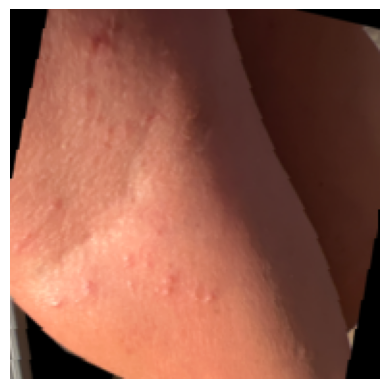

torch.Size([192, 192, 3])

In [21]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# Load an image using PIL (you can replace this with your image path)
image_path = new_df.loc[50]['image_path']
image = Image.open(image_path)

# Convert the image to a PyTorch tensor
# transform =  transforms.Compose([ transforms.Resize((244, 244)),
#                                 transforms.RandomResizedCrop(192, scale=(0.8, 1.0)),
#                                 transforms.ToTensor()
#                                 ])

transform =  transforms.Compose([
#         transforms.Resize((512, 512)),
#         transforms.ColorJitter(0.5, 0.5, 0.5, 0.1),
#         transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),  
        transforms.RandomHorizontalFlip(p=0.3),  # Horizontal flip with 50% probability
        transforms.RandomVerticalFlip(p=0.3),   
        transforms.RandomResizedCrop(192, scale=(0.8, 1.0)),
        transforms.RandomAffine(degrees=0, shear=10),
#         transforms.ColorJitter(0.25, 0.25, 0.25, 0.1),
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.float),        
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
image_tensor = transform(image)

# Convert the image tensor from [C, H, W] to [H, W, C] for displaying
image_tensor = image_tensor.permute(1, 2, 0)

# Plot the image using matplotlib
plt.imshow(image_tensor)
plt.axis('off')  # Hide axes for better visual appearance
plt.show()
image_tensor.shape

In [22]:
image_tensor.shape

torch.Size([192, 192, 3])

In [23]:
# Filter out missing labels and images
filtered_df = merged_df.dropna(subset=['eczema', 'image_path'])

# Split data into training and validation sets
train_df, val_df = train_test_split(filtered_df, test_size=0.2, random_state=42)


In [24]:
train_df['eczema'].value_counts()

eczema
0    457
1    187
Name: count, dtype: int64

In [25]:
val_df['eczema'].value_counts()

eczema
0    110
1     51
Name: count, dtype: int64

In [26]:
# Import necessary libraries
from torch.utils.data import Dataset
from PIL import Image
import torch

# Define custom dataset class
class EczemaDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.iloc[idx]['image_path']
        image = Image.open(image_path).convert('RGB')
        label = self.df.iloc[idx]['eczema']

        image = self.transform(image)
        label = torch.tensor(label, dtype=torch.float)
#         label = torch.tensor(label)


        return image, label

In [27]:
import torchvision.transforms as transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomRotation(15),  
        transforms.RandomHorizontalFlip(p=0.3),  # Horizontal flip with 50% probability
        transforms.RandomVerticalFlip(p=0.3),   
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.float),        
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.float),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [28]:
import torch.nn as nn
import torchvision.models as models

# Define model
class EczemaClassifier(nn.Module):
    def __init__(self):
        super(EczemaClassifier, self).__init__()
#         self.model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
        self.model = torchvision.models.resnet152(weights=torchvision.models.ResNet152_Weights.DEFAULT)
        # Freeze layers except for the final one
        for param in self.model.parameters():
            param.requires_grad = False        

        self.model.fc = nn.Linear(self.model.fc.in_features, 1)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.model(x)
        x = self.dropout(x)
        return x

In [29]:
len(train_df), len(val_df)

(644, 161)

In [30]:
def save_model(model_name, model, epoch, val_acc):
    scripted_model = torch.jit.script(model)
    torch.jit.save(scripted_model, f'{model_name}-{epoch}-{val_acc:.4f}.pth')

In [31]:
# Train model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device={device}')

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

device=cuda


In [32]:
import torch
from collections import Counter

# Step 1: Load and prepare your dataset (assuming your dataset is loaded into `train_df`)
# Assuming labels are stored in a column named 'label'

# Check the distribution of the classes in your dataset
class_counts = Counter(train_df['eczema'])
print(f"Class distribution: {class_counts}")

# Step 2: Calculate the number of samples for each class
num_positive = class_counts[1]
num_negative = class_counts[0]

print(f"Number of positive samples: {num_positive}")
print(f"Number of negative samples: {num_negative}")

# Step 3: Compute the pos_weight
# pos_weight is typically set to the ratio of negative to positive examples
pos_weight = num_negative / num_positive
print(f"Pos weight calculated: {pos_weight}")

Class distribution: Counter({0: 457, 1: 187})
Number of positive samples: 187
Number of negative samples: 457
Pos weight calculated: 2.443850267379679


In [33]:
def compute_AUC(gt, pred):
    AUROCs = []
    gt_np = gt.detach().cpu().numpy()
    pred_np = pred.detach().cpu().numpy()
    AUROC = roc_auc_score(gt_np, pred_np)
    return AUROC

In [34]:
# Create data loaders
train_dataset = EczemaDataset(train_df, data_transforms['train'])
val_dataset = EczemaDataset(val_df, data_transforms['val'])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=750, shuffle=True) # 750
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False) #256

In [35]:
model = EczemaClassifier().to(device)

pos_weight_tensor = torch.tensor([pos_weight]).to(device)
print(f"pos_weight_tensor={pos_weight_tensor}")
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

best_AUROC = 0.0
global_step = 0
global_epochs = 0

pos_weight_tensor=tensor([2.4439], device='cuda:0')


In [36]:
for epoch in range(250):
    start_time = time.time()  # Start timer
    all_gt_labels_train = torch.FloatTensor().to(device)
    total_preds_train = torch.FloatTensor().to(device)

    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
#         labels = labels.unsqueeze(1)
        global_epochs += 1
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).squeeze()

        all_gt_labels_train = torch.cat((all_gt_labels_train, labels), 0)
        total_preds_train = torch.cat((total_preds_train, outputs), 0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        writer.add_scalar('resnet-Loss/train', loss.item(), global_epochs)
                
        running_loss += loss.item()
    
    AUROC_TRAIN = compute_AUC(all_gt_labels_train, total_preds_train)
#     AUROC_TRAIN = compute_AUC(all_gt_labels_train, torch.softmax(total_preds_train, dim=1)[:, 1])
    writer.add_scalar('resnet-Loss/train-AUROC', AUROC_TRAIN, global_epochs)

    
    end_time = time.time()  # End timer
    epoch_time = end_time - start_time
    global_step += 1
    
    if global_step % 3 !=0:
        print(f'Epoch: {global_step}, Training Loss: {(running_loss / len(train_loader)):.4f}, AUROC_TRAIN:{AUROC_TRAIN:.4f},  Time: {epoch_time:.2f} seconds ')
    else:
        model.eval()
        with torch.no_grad():
            all_gt_labels_val = torch.FloatTensor().to(device)
            total_preds_val = torch.FloatTensor().to(device)
            
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                predicted = model(images).squeeze()
                all_gt_labels_val = torch.cat((all_gt_labels_val, labels), 0)
                total_preds_val = torch.cat((total_preds_val, predicted), 0)

            AUROC_VAL = compute_AUC(all_gt_labels_val, total_preds_val)
#             AUROC_VAL = compute_AUC(all_gt_labels_val, torch.softmax(total_preds_val, dim=1)[:, 1])
            if best_AUROC < AUROC_VAL:
                best_AUROC = AUROC_VAL
                #change model output file name
                save_model('ResNet18-BCE-adam-no-scheduler',model,global_step,AUROC_VAL)                
                
            print(f'Epoch: {global_step}, Training Loss: {(running_loss / len(train_loader)):.4f}, AUROC_TRAIN:{AUROC_TRAIN:.4f}, Time: {epoch_time:.2f} seconds, AUROC_VALID:{AUROC_VAL:.4f}')
            writer.add_scalar('resnet-Loss/validation-AUROC', AUROC_VAL, global_epochs)

Epoch: 1, Training Loss: 0.9904, AUROC_TRAIN:0.4985,  Time: 25.02 seconds 
Epoch: 2, Training Loss: 1.0275, AUROC_TRAIN:0.5999,  Time: 17.29 seconds 
Epoch: 3, Training Loss: 1.3047, AUROC_TRAIN:0.5346, Time: 16.67 seconds, AUROC_VALID:0.4806
Epoch: 4, Training Loss: 0.9725, AUROC_TRAIN:0.6234,  Time: 18.35 seconds 
Epoch: 5, Training Loss: 1.0709, AUROC_TRAIN:0.5831,  Time: 17.67 seconds 
Epoch: 6, Training Loss: 1.0889, AUROC_TRAIN:0.6257, Time: 17.38 seconds, AUROC_VALID:0.4882
Epoch: 7, Training Loss: 0.9348, AUROC_TRAIN:0.6804,  Time: 17.81 seconds 
Epoch: 8, Training Loss: 0.9528, AUROC_TRAIN:0.6641,  Time: 17.07 seconds 
Epoch: 9, Training Loss: 1.0143, AUROC_TRAIN:0.6466, Time: 17.42 seconds, AUROC_VALID:0.4811
Epoch: 10, Training Loss: 0.9490, AUROC_TRAIN:0.6864,  Time: 17.19 seconds 
Epoch: 11, Training Loss: 0.8939, AUROC_TRAIN:0.7048,  Time: 16.76 seconds 
Epoch: 12, Training Loss: 0.9055, AUROC_TRAIN:0.7211, Time: 17.19 seconds, AUROC_VALID:0.4658
Epoch: 13, Training Loss:

Epoch: 102, Training Loss: 0.6268, AUROC_TRAIN:0.8824, Time: 16.49 seconds, AUROC_VALID:0.4786
Epoch: 103, Training Loss: 0.5805, AUROC_TRAIN:0.9201,  Time: 16.88 seconds 
Epoch: 104, Training Loss: 0.6057, AUROC_TRAIN:0.8947,  Time: 16.55 seconds 
Epoch: 105, Training Loss: 0.6139, AUROC_TRAIN:0.8902, Time: 16.50 seconds, AUROC_VALID:0.4772
Epoch: 106, Training Loss: 0.6095, AUROC_TRAIN:0.9023,  Time: 17.00 seconds 
Epoch: 107, Training Loss: 0.6041, AUROC_TRAIN:0.8963,  Time: 16.68 seconds 
Epoch: 108, Training Loss: 0.5897, AUROC_TRAIN:0.9101, Time: 16.63 seconds, AUROC_VALID:0.4772
Epoch: 109, Training Loss: 0.6146, AUROC_TRAIN:0.8946,  Time: 16.54 seconds 
Epoch: 110, Training Loss: 0.5925, AUROC_TRAIN:0.9015,  Time: 16.48 seconds 
Epoch: 111, Training Loss: 0.6210, AUROC_TRAIN:0.8894, Time: 16.34 seconds, AUROC_VALID:0.4781
Epoch: 112, Training Loss: 0.5869, AUROC_TRAIN:0.9095,  Time: 16.57 seconds 
Epoch: 113, Training Loss: 0.5929, AUROC_TRAIN:0.9087,  Time: 16.63 seconds 
Epoc

Epoch: 201, Training Loss: 0.5221, AUROC_TRAIN:0.9275, Time: 16.70 seconds, AUROC_VALID:0.4672
Epoch: 202, Training Loss: 0.5496, AUROC_TRAIN:0.9081,  Time: 16.92 seconds 
Epoch: 203, Training Loss: 0.4988, AUROC_TRAIN:0.9272,  Time: 16.44 seconds 
Epoch: 204, Training Loss: 0.4886, AUROC_TRAIN:0.9339, Time: 16.59 seconds, AUROC_VALID:0.4642
Epoch: 205, Training Loss: 0.5362, AUROC_TRAIN:0.9192,  Time: 16.47 seconds 
Epoch: 206, Training Loss: 0.5113, AUROC_TRAIN:0.9205,  Time: 16.69 seconds 
Epoch: 207, Training Loss: 0.5254, AUROC_TRAIN:0.9189, Time: 16.53 seconds, AUROC_VALID:0.4633
Epoch: 208, Training Loss: 0.4998, AUROC_TRAIN:0.9243,  Time: 16.80 seconds 
Epoch: 209, Training Loss: 0.5360, AUROC_TRAIN:0.9158,  Time: 16.45 seconds 
Epoch: 210, Training Loss: 0.5078, AUROC_TRAIN:0.9266, Time: 16.38 seconds, AUROC_VALID:0.4635
Epoch: 211, Training Loss: 0.4996, AUROC_TRAIN:0.9301,  Time: 16.33 seconds 
Epoch: 212, Training Loss: 0.5213, AUROC_TRAIN:0.9228,  Time: 16.63 seconds 
Epoc

In [37]:
# scripted_model = torch.jit.script(model)
# torch.jit.save(scripted_model, 'resnet18-model-eczema-0.7815.pth')

In [38]:
# loaded_model = loaded_model = torch.jit.load('resnet18-model-eczema-0.7815.pth')